# 08. Milestone Project 2: PyTorch Paper Replicating
The goal of machine learning research paper replicating is: turn a ML research paper into usable code.

In this notebook, we're going to be replicating the Vision Transformer (ViT) architecture/paper with PyTorch: https://arxiv.org/abs/2010.11929

See ground truth notebook here: https://www.learnpytorch.io/08_pytorch_paper_replicating/

In [1]:
!nvidia-smi

Thu Oct 31 09:51:00 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## 0. Get setup


In [3]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torchvision import transforms


# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from torchinfo import summary
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary


    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves


In [4]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device



'cuda'

## 1. Get data
The whole goal of what we're trying to do is to replicate the ViT architecture for our FoodVision Mini problem.

To do that, we need some data.

Namely, the pizza, steak and sushi images we've been using so far.

In [5]:
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path


[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [6]:
image_path

PosixPath('data/pizza_steak_sushi')

In [7]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir


(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2. Create Datasets and DataLoaders


In [8]:
from going_modular.going_modular import data_setup
from torchvision import transforms

IMAGE_SIZE=(224,224) # comes from Table 3 of the ViT paper

manual_transforms= transforms.Compose([
    transforms.Resize(size=IMAGE_SIZE),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

manual_transforms

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

In [9]:
# Create a batch size of 32 (gthe paper uses 4096 but this may be too big for our smaller hardware)
BATCH_SIZE=32

train_dataloader, test_dataloader, class_names= data_setup.create_dataloaders(train_dir= train_dir,
                                                                             test_dir= test_dir,
                                                                             transform= manual_transforms,
                                                                             batch_size= BATCH_SIZE)

train_dataloader, test_dataloader, class_names


(<torch.utils.data.dataloader.DataLoader at 0x76ef114916a0>,
 ['pizza', 'steak', 'sushi'])

In [10]:
len(train_dataloader)

8

### 2.1 Visualize a single a image
As always, let's adhere to the motto, visualize, visualize, visualize!

In [11]:

image_batch, label_batch= next(iter(test_dataloader))
image, label= image_batch[0], label_batch[0]
image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

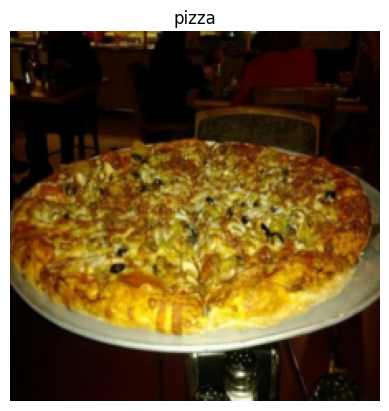

In [12]:
import matplotlib.pyplot as plt
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

## 3. Replicating ViT: Overview

Looking at a whole machine learning research paper can be imtimidating.

So in order to make it more understandable, we can break it down into smaller pieces:

- Inputs - What goes into the model? (in our case, image tensors)
- Outputs - What comes out of the model/layer/block? (in our case, we want the model to output image classification labels)
- Layers - Takes an input, manipulates it with a function (for example could be self-attention).
- Blocks - A collection of layers.
- Model (or architecture) - A collection of blocks.

### 3.1 ViT overview: pieces of the puzzle

- Figure 1: Visual overview of the architecture
- Four equations: math equations which define the functions of each layer/block
- Table 1/3: different hyperparameters for the architecture/training.
- Text descriptions (especially section 3.1)


### Figure 1

![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-architecture-overview.png)

Embedding = learnable representation (start with random numbers and improve over time)





### Four equations

![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/images/08-vit-paper-four-equations.png)

**Section 3.1 describes the various equations:**

**Equation 1:** An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle 2D images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2 D patches $\mathbf{x}_p \in \mathbb{R}^{N \times\left(P^2 \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

**Equation 1:** Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

In pseudocode:

```python
# Equation 1
x_input = [class_token, image_patch_1, image_patch_2, ... image_patch_N] +
[class_token_pos, image_patch_1_pos, image_patch_2_pos, ... image_patch_N_pos]
```
---

**Equation 2 & 3:** The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before - every block, and residual connections after every block (Wang et al., 2019; Baevski \& Auli, 2019).

In pseudocode:

```python
#Equation 2

x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input

#Equation 3

x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block
```
---

**Equation 4:** Similar to BERT's [class] token, we prepend a learnable embedding to the sequence of embedded patches $\left(\mathbf{z}_0^0=\mathbf{x}_{\text {class }}\right)$, whose state at the output of the Transformer encoder ( $\mathbf{z}_L^0$ ) serves as the image representation $y$ (Eq. 4). Both during pre-training and fine-tuning, a classification head is attached to $\mathrm{z}_L^0$. The classification head is implemented by a MLP with one hidden layer at pre-training time and by a single linear layer at fine-tuning time.

- MLP = multilayer perceptron = a neural network with X number of layers
- MLP = one hidden layer at training time
- MLP = single linear layer at fine-tuning time

In pseudocode:

```python
#Equation 4

y = Linear_layer(LN_layer(x_output_MLP_block))
```


### Table 1

![image.png](attachment:image.png)

- ViT-Base, ViT-Large and ViT-Huge are all different sizes of the same model architecture
- ViT-B/16 = ViT-Base with image patch size 16x16
- Layers - the number of transformer encoder layers
- Hidden size $D$ -the embedding size throughout the architecture
- MLP size - the number of hidden units/neurons in the MLP
- Heads - the number of multi-head self-attention


## 4. Equation 1: Split data into patches and creating the class, position and patch embedding
Layers = input -> function -> output

What's the input shape?

What's the output shape?

- Input shape: (224, 224, 3) -> single image -> (height, width, color channels)
- Output shape: ???

### 4.1 Calculate input and output shapes by hand

>**Equation 1:** An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle 2D images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2 D patches $\mathbf{x}_p \in \mathbb{R}^{N \times\left(P^2 \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

>**Equation 1:** Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

- input shape: $H \times W \times C$(height x width x color channels)
- Output shape: $N \times (P^2 \cdot C)$
- H = height
- W = width
- C = color channels
- P = patch size
- N = number of patches = (height * width) / p^2
- D = constant latent vector size = embedding dimension (see Table 1)

In [15]:
#### Create example values
height= 224
width= 224
color_channels= 3
patch_size= 16

# Calculate the number of patches
number_of_patches= int((height*width)/patch_size**2)
number_of_patches

196

In [16]:
224*224 // 16**2

196

In [17]:
embedding_layer_input_shape= (height, width, color_channels)
embedding_layer_output_shape= (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 1D sequence of patches): {embedding_layer_output_shape} -> (number_of_patches, embedding_dimension)")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D sequence of patches): (196, 768) -> (number_of_patches, embedding_dimension)


In [18]:
(196, 16*16*3)

(196, 768)

### 4.2 Turning a single image into patches


(-0.5, 223.5, 223.5, -0.5)

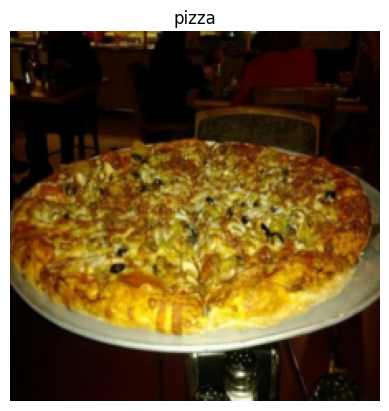

In [19]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis('off')

In [20]:
image.shape

torch.Size([3, 224, 224])

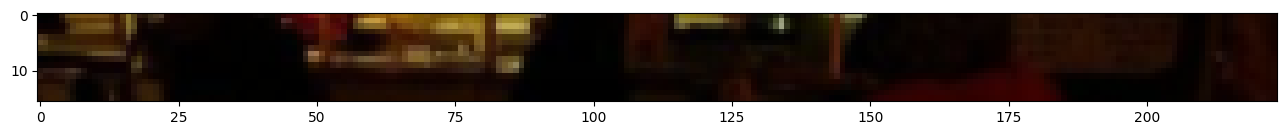

In [21]:
# Get the top row of the image
image_permuted= image.permute(1,2,0)

# Index to plot the top row of the pixels
patch_size= 16
plt.figure(figsize=(patch_size,patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

Number of patches per row: 14
Patch size: 16 pixels x 16 pixels


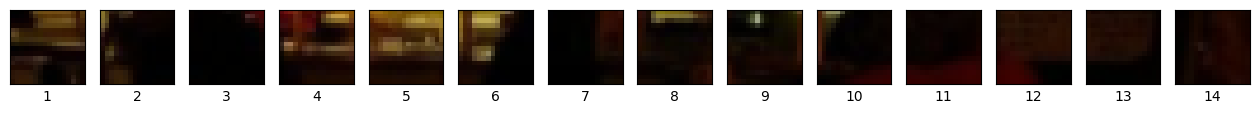

In [22]:
# Plot top row as patches
image_size= 224
patch_size= 16
num_patches= image_size//patch_size

assert image_size%patch_size==0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs= plt.subplots(nrows=1, ncols= image_size//patch_size,
                       sharex=True, sharey=True,
                       figsize=(patch_size, patch_size))

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, image_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :])
    axs[i].set_xlabel(i+1)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row: 14
Number of patches per column: 14
Total patches: 196
Patch size: 16 pixels x 16 pixels


Text(0.5, 0.98, 'pizza -> Patchified')

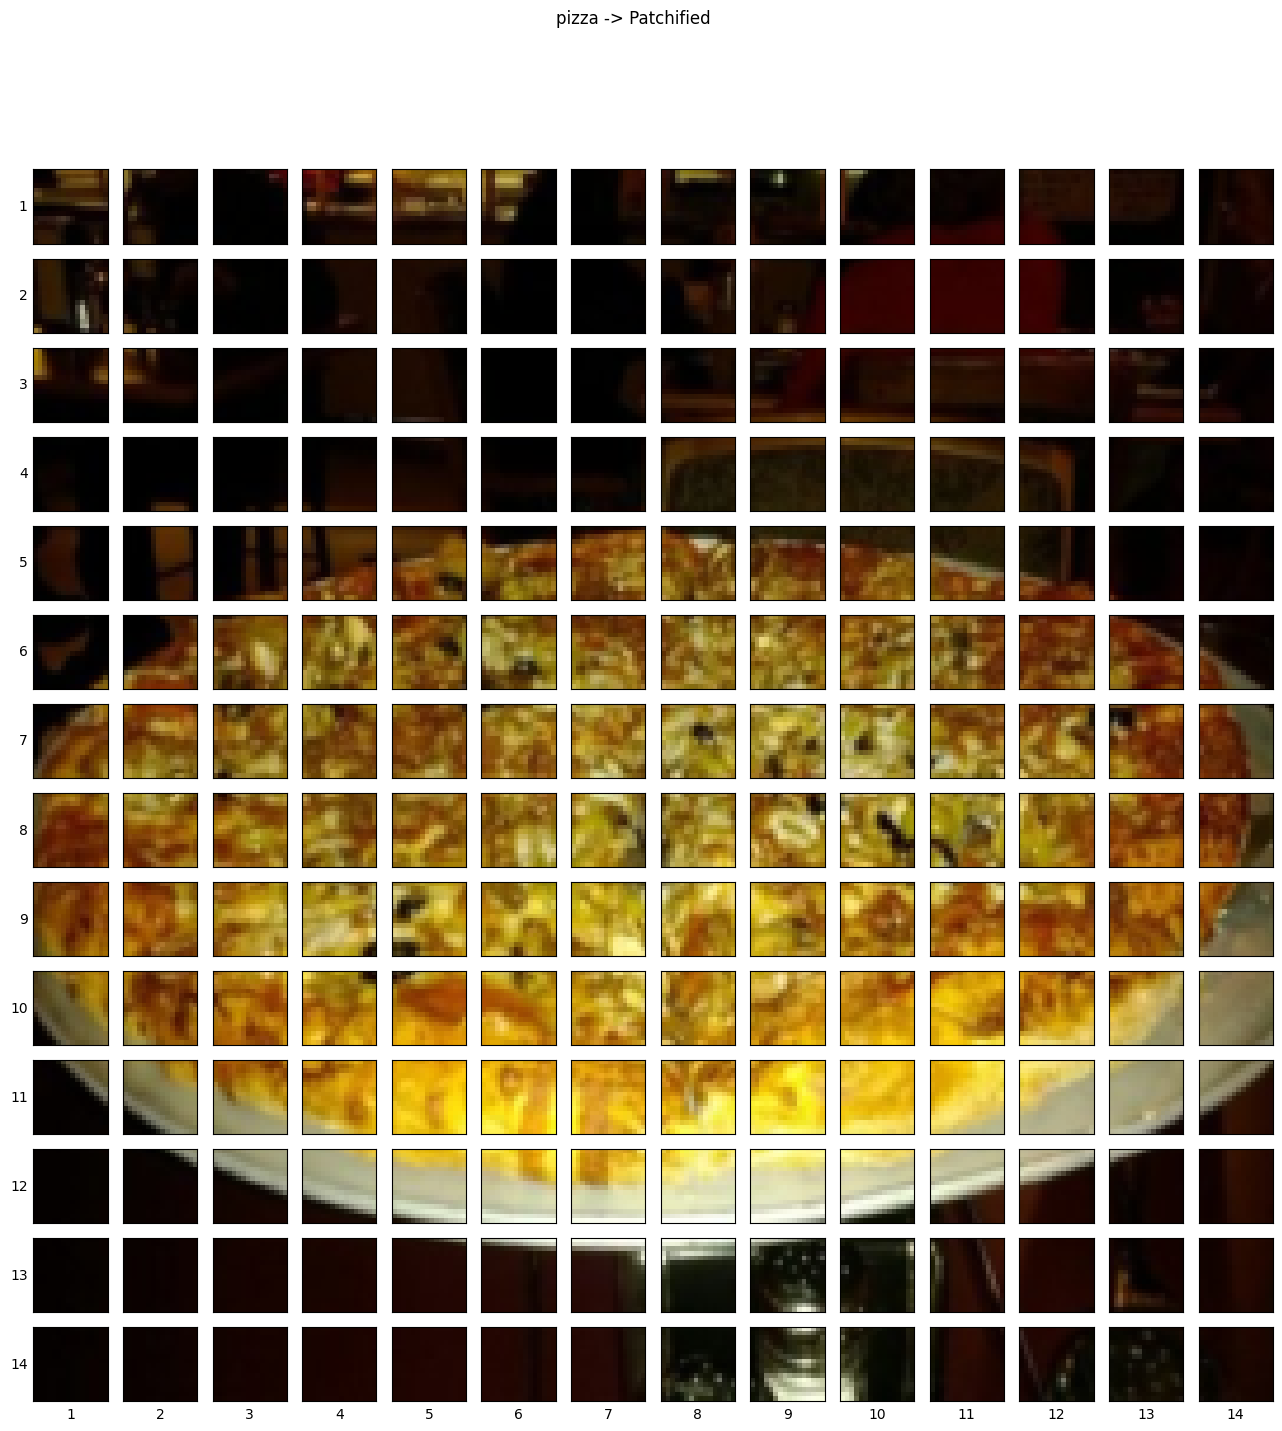

In [23]:
# Plot whole image as patches
image_size=224
patch_size=16
num_patches= image_size//patch_size

assert image_size%patch_size==0, "Image size must be divisible by patch size"

print(f"Number of patches per row: {num_patches}\n\
Number of patches per column: {num_patches}\n\
Total patches: {num_patches**2}\n\
Patch size: {patch_size} pixels x {patch_size} pixels")

fig, axs= plt.subplots(nrows= num_patches, ncols= num_patches,
                      sharex=True, sharey=True,
                      figsize=(patch_size, patch_size))

for i, patch_height in enumerate(range(0, image_size, patch_size)):
    for j, patch_width in enumerate(range(0,image_size, patch_size)):

        axs[i,j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                      patch_width:patch_width+patch_size, # iterate through width
                                      :]) # iterate through all color channels

        axs[i,j].set_xlabel(j+1)
        axs[i,j].set_ylabel(i+1,
                           rotation='horizontal',
                           horizontalalignment='right',
                           verticalalignment='center')
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
        axs[i,j].label_outer()

plt.suptitle(f"{class_names[label]} -> Patchified")

### 4.3 Creating image patches and turning them into patch embeddings
Perhaps we could create the image patches and image patch embeddings in a single step using `torch.nn.Conv2d()` and setting the kernel size and stride parameters to `patch_size`.

In [24]:
# Create conv2d layer to turn image into patches of learnable feature maps (embeddings)
from torch import nn

patch_size=16

# Create a conv2d lyaer with hyperparameters from the ViT paper
conv2d= nn.Conv2d(in_channels=3, # Coloe channels
                 out_channels=768, # D size from Table 1 for ViT-Base
                 kernel_size= patch_size,
                 stride= patch_size,
                 padding= 0)

conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

In [25]:
16*16*3

768

(-0.5, 223.5, 223.5, -0.5)

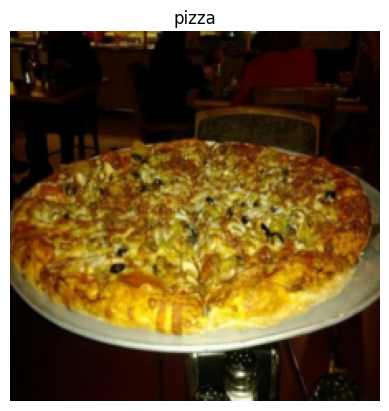

In [26]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

In [27]:
image.shape

torch.Size([3, 224, 224])

In [28]:
# Pass the image through the convolutional layer
image_out_of_conv= conv2d(image.unsqueeze(0)) # add batch dimention
image_out_of_conv.shape

torch.Size([1, 768, 14, 14])

In [29]:
3*224*224

150528

In [30]:
224/16

14.0

In [31]:
14*14

196

In [32]:
3* 16*16

768

In [33]:
3 * 16*16 * 196

150528

In [34]:
image_out_of_conv.requires_grad

True

Now we've passed a single image to our conv2d layer, it's shape is:
```python
torch.Size([1, 768, 14, 14]) # [batch_size, embedding_dim, feature_map_height, feature_map_width]
```

Showing random convolutional feature maps from indexes: [711, 111, 518, 521, 672]


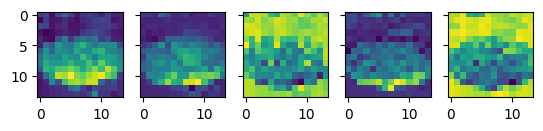

In [35]:
# Plot random convolutional feature maps (embeddings)
import random
random_indexes= random.sample(range(0,768), k=5)
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

fig,axs= plt.subplots(nrows=1, ncols=5)

for i, idx in enumerate(random_indexes):
    axs[i].imshow(image_out_of_conv[0,idx,:,:].detach().numpy())
    axs[i].label_outer()

In [36]:
image_out_of_conv[0,1].shape

torch.Size([14, 14])

In [37]:
image_out_of_conv[0,1].detach()[0]

tensor([0.1298, 0.0224, 0.0519, 0.1384, 0.3238, 0.0205, 0.0930, 0.0980, 0.1258,
        0.0467, 0.0983, 0.1049, 0.0429, 0.1098])

In [38]:
image_out_of_conv[0,1].detach().numpy()[0]

array([0.12984505, 0.02235866, 0.05193155, 0.1384385 , 0.32381815,
       0.02052257, 0.09299479, 0.09795205, 0.12583122, 0.04672405,
       0.09833255, 0.10493007, 0.0428516 , 0.10977995], dtype=float32)

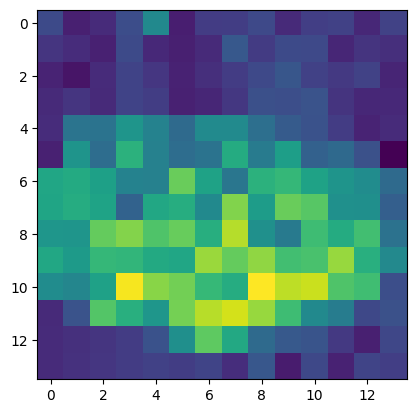

In [39]:
plt.imshow(image_out_of_conv[0,1,:,:].detach())

True


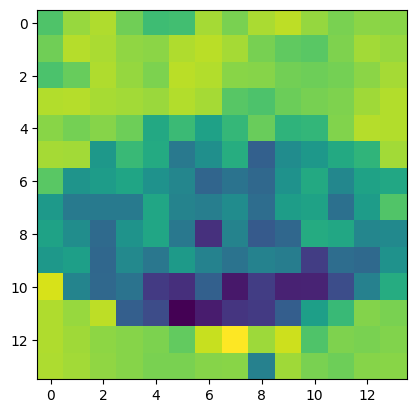

In [40]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
print(single_feature_map.requires_grad)
plt.imshow(single_feature_map.detach().squeeze())


In [41]:
image_out_of_conv.shape

torch.Size([1, 768, 14, 14])

In [42]:
224*224*3/(16*16*3)


196.0

In [43]:
224*224/(16*16)

196.0

In [44]:
14*14

196

In [45]:
16*16*3

768

In [46]:

14*14 * 16*16*3

150528

In [47]:
768 * 14*14

150528

### 4.4 Flattening the patch embedding with `torch.nn.Flatten()`

Right now we've a series of convolutional feature maps (patch embeddings) that we want to flatten into a sequence of patch embeddings to satisfy the input criteria of the ViT Transformer Encoder.

In [48]:
print(f"{image_out_of_conv.shape} -> [batch_size, embedding_dim, feature_map_height, feature_map_width]")

torch.Size([1, 768, 14, 14]) -> [batch_size, embedding_dim, feature_map_height, feature_map_width]


Want: [batch_size, number_of_patches, embedding_dim] -> [1, 196, 768]

In [49]:
flatten_layer= nn.Flatten(start_dim=2, end_dim=3)

flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

Original image shape: torch.Size([3, 224, 224])
Image feature map (patches) shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


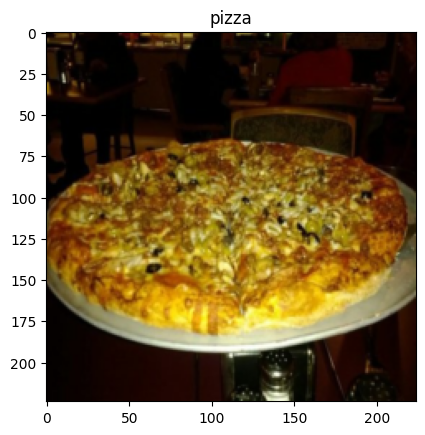

In [50]:
# Put everything together
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
print(f"Original image shape: {image.shape}")

# Turn image into feature maps
image_out_of_conv= conv2d(image.unsqueeze(0)) # add batch dimention
print(f"Image feature map (patches) shape: {image_out_of_conv.shape}")

# Flatten the feature maps
image_out_of_conv_flattened= flatten_layer(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [51]:
# Rearrange output of flattened layer
print(f"{image_out_of_conv_flattened.permute(0,2,1).shape} -> (batch_size, number_of_patches, embedding_dimention)")

torch.Size([1, 196, 768]) -> (batch_size, number_of_patches, embedding_dimention)


(-0.5, 195.5, 0.5, -0.5)

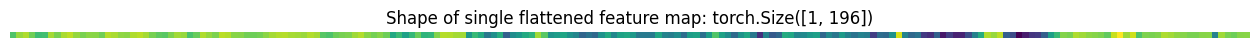

In [52]:
single_flattened_feature_map= image_out_of_conv_flattened.permute(0,2,1)[:,:,0]

plt.figure(figsize=(16,16))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Shape of single flattened feature map: {single_flattened_feature_map.shape}")
plt.axis(False)

### 4.5 Turning the ViT patch embedding layer into a PyTorch module

We want this module to do a few things:

1. Create a class called `PatchEmbedding` that inherits from `nn.Module`.
2. Initialize with appropriate hyperparameters, such as channels, embedding dimension, patch size.
3. Create a layer to turn an image into embedded patches using `nn.Conv2d()`.
4. Create a layer to flatten the feature maps of the output of the layer in 3.
5. Define a `foward()` that defines the forward computation (e.g. pass through layer from 3 and 4).
6. Make sure the output shape of the layer reflects the required output shape of the patch embedding.

In [53]:
# 1. Create a class PatchEmbedding
class PatchEmbedding(nn.Module):
    # 2. Initialize the layer with appropriate hyperparameters
    def __init__(self,
                in_channels:int=3,
                patch_size:int=16,
                embedding_dim:int=768): # from Table 1 from ViT-Base
        super().__init__()

        # 3. Create a layer to turn an image into embedded patches
        self.patcher=nn.Conv2d(in_channels=in_channels,
                              out_channels=embedding_dim,
                              kernel_size=patch_size,
                              stride=patch_size,
                              padding=0)

        # 4. Create a layer to flatten the feature maps outputs of Conv2d
        self.flatten=nn.Flatten(start_dim=2,
                               end_dim=3)

    # 5. Define a foward method that defines the forward computation steps
    def forward(self,x):
        # Create assertion to check that inputs are the correct shape
        image_resolution= x.shape[-1]
        assert image_resolution%patch_size==0, f"Input image size must be divisible by patch size, image size: {image_resolution}, patch size: {patch_size}"

        # Perform the forward pass
        x_patched=self.patcher(x)
        x_flattened=self.flatten(x_patched)

        # 6. Make the returned sequence embedding dimensions are in the right order (batch_size, number_of_patches, embedding_dimension)
        return x_flattened.permute(0,2,1)

In [54]:
224%16

0

In [55]:
set_seeds()

patchify= PatchEmbedding(in_channels=3,
                        patch_size=16,
                        embedding_dim=768)

print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image= patchify(image.unsqueeze(0))
print(f"Output patch embedding sequence shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding sequence shape: torch.Size([1, 196, 768])


In [56]:
rand_image_tensor=torch.randn(1,3,224,224)
rand_image_tensor_bad=torch.randn(1,3,225,225)

#patchify(rand_image_tensor_bad)

### 4.6 Creating the class token embedding

Want to: prepend a learnable class token to the start of the patch embedding

In [57]:
patch_embedded_image

tensor([[[-0.2147, -0.0344, -0.0854,  ...,  0.1379, -0.0368, -0.0306],
         [ 0.0552, -0.0636, -0.0535,  ..., -0.0201, -0.0180,  0.0531],
         [-0.0253, -0.0075, -0.0489,  ...,  0.0090, -0.0283, -0.0102],
         ...,
         [ 0.0026, -0.0232, -0.0519,  ...,  0.0559, -0.0052,  0.0426],
         [-0.1267, -0.0137, -0.0448,  ...,  0.0350, -0.0474, -0.0056],
         [-0.0803, -0.0184, -0.0172,  ...,  0.0517, -0.0325,  0.0041]]],
       grad_fn=<PermuteBackward0>)

In [58]:
batch_size= patch_embedded_image.shape[0]
embedding_dimention= patch_embedded_image.shape[-1]

batch_size, embedding_dimention

(1, 768)

In [59]:
# Create class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token= nn.Parameter(torch.ones(batch_size,1,embedding_dimention),
                         requires_grad=True)

class_token.shape

torch.Size([1, 1, 768])

In [60]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [61]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding= torch.cat((class_token, patch_embedded_image),
                                                    dim=1) # concat on first dimension

print(f"Sequence of patch embeddings with class token prepended shape:\n\t{patch_embedded_image_with_class_embedding.shape} -> (batch_size, class_token + number_of_patches, embedding_dim)")
print('\n',patch_embedded_image_with_class_embedding)

Sequence of patch embeddings with class token prepended shape:
	torch.Size([1, 197, 768]) -> (batch_size, class_token + number_of_patches, embedding_dim)

 tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.2147, -0.0344, -0.0854,  ...,  0.1379, -0.0368, -0.0306],
         [ 0.0552, -0.0636, -0.0535,  ..., -0.0201, -0.0180,  0.0531],
         ...,
         [ 0.0026, -0.0232, -0.0519,  ...,  0.0559, -0.0052,  0.0426],
         [-0.1267, -0.0137, -0.0448,  ...,  0.0350, -0.0474, -0.0056],
         [-0.0803, -0.0184, -0.0172,  ...,  0.0517, -0.0325,  0.0041]]],
       grad_fn=<CatBackward0>)


 ### 4.7 Creating the position embedding
    
Want to: create a series of 1D learnable position embeddings and to add them to the sequence of patch embeddings.

In [62]:
# Calculate N (number of patches)
number_of_patches= int((height*width)/patch_size**2)
number_of_patches

196

In [63]:
(224*224)/16**2

196.0

In [64]:
embedding_dimention= patch_embedded_image_with_class_embedding.shape[-1]
embedding_dimention

768

In [65]:
# Create the position embedding
position_embedding= nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimention))
position_embedding.shape, position_embedding

(torch.Size([1, 197, 768]),
 Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True))

In [66]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding= patch_embedded_image_with_class_embedding + position_embedding
patch_and_position_embedding.shape, patch_and_position_embedding

(torch.Size([1, 197, 768]),
 tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
          [0.7853, 0.9656, 0.9146,  ..., 1.1379, 0.9632, 0.9694],
          [1.0552, 0.9364, 0.9465,  ..., 0.9799, 0.9820, 1.0531],
          ...,
          [1.0026, 0.9768, 0.9481,  ..., 1.0559, 0.9948, 1.0426],
          [0.8733, 0.9863, 0.9552,  ..., 1.0350, 0.9526, 0.9944],
          [0.9197, 0.9816, 0.9828,  ..., 1.0517, 0.9675, 1.0041]]],
        grad_fn=<AddBackward0>))

In [67]:
torch.tensor([1,1,1])+torch.tensor([1,1,1])

tensor([2, 2, 2])

### 4.8 Putting it all together: from image to embedding

We've written code to turn an image into a flattened sequence of patch embeddings.

Now let's it all in one cell.

In [68]:
# Set seed
set_seeds()

# Set the patch size
patch_size=16

# Print shape of the original image tensor and get the image dimentions
print(f"Image tensor shape: {image.shape}")
height, width= image.shape[1], image.shape[2]

# Get image tensor and add a batch dimention
x= image.unsqueeze(0)
print(f"Input image shape: {x.shape}")

# Create patch embedding layer
patch_embedding_layer= PatchEmbedding(in_channels=3,
                                     patch_size= patch_size,
                                     embedding_dim= 768)

# Pass input image through PatchEmbedding
patch_embedding= patch_embedding_layer(x)
print(f"Patch embedding shape: {patch_embedding.shape}")

# Create class token embedding
batch_size= patch_embedding.shape[0]
embedding_dimention= patch_embedding.shape[-1]
class_token= nn.Parameter(torch.ones(batch_size, 1, embedding_dimention),
                         requires_grad=True) # to make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

# Prepend the class token embedding to patch embedding
patch_embedding_class_token= torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# Create position embedding
number_of_patches= int((height*width)/patch_size**2)
position_embedding= nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimention),
                                requires_grad=True) # to make sure it's learnable
print(f"Position embedding shape: {position_embedding.shape}")

# Add the position embedding to patch embedding with class token embedding
patch_and_position_embedding= patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Position embedding shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


## 5. Equation 2: Multihead Self-Attention (MSA block)

- Multihead self-attention = which part of a sequence should pay the most attention to itself?

    - In our case, we have a series of embedded image patches, which patch significantly relates to another patch.
    - We want our neural network (ViT) to learn this relationship/representation.

- To replicate MSA in PyTorch we can use: https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html


- LayerNorm = Layer normalization (LayerNorm) is a technique to normalize the distributions of intermediate layers. It enables smoother gradients, faster training, and better generalization accuracy.

    - Normalization = make everything have the same mean and same standard deviation.
    - In PyTorch = https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html, normalizes values over $D$ dimension, in our case, the $D$ dimension is the embedding dimension.
             
         - When we normalize along the embedding dimension, it's like making all of the stairs in a staircase the same size.

In [69]:
class MultiHeadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short)."""
    def __init__(self,
                embedding_dim:int=768, # Hidden size D (embedding dimention) from Table 1 for ViT-Base
                num_heads:int=12, # Heads from Table 1 for ViT-Base
                attn_dropout:int=0):
        super().__init__()

        # Create the norm layer (LN)
        self.layer_norm= nn.LayerNorm(normalized_shape=embedding_dim)

        # Create multihead attention (MSA) layer
        self.multihead_attn= nn.MultiheadAttention(embed_dim=embedding_dim,
                                                       num_heads=num_heads,
                                                       dropout=attn_dropout,
                                                       batch_first=True) # (batch, seq, feature) = (batch, number_of_patches, embedding_dimension)

    def forward(self, x):
        x= self.layer_norm(x)
        attn_output, _= self.multihead_attn(query=x, key=x, value=x, need_weights=False)

        return attn_output

In [70]:
# Create an instance of MSA block
multihead_self_attention_block= MultiHeadSelfAttentionBlock(embedding_dim=768,
                                                           num_heads=12,
                                                           attn_dropout=0)

# Pass the patch and position image embedding sequence through MSA block
patched_image_through_msa_block= multihead_self_attention_block(patch_and_position_embedding)

print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape of MSA block: {patched_image_through_msa_block.shape}")


Input shape of MSA block: torch.Size([1, 197, 768])
Output shape of MSA block: torch.Size([1, 197, 768])


In [71]:
patch_and_position_embedding.shape

torch.Size([1, 197, 768])

In [72]:
multihead_self_attention_block

MultiHeadSelfAttentionBlock(
  (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (multihead_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
)

In [73]:
patch_and_position_embedding

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.7853, 0.9656, 0.9146,  ..., 1.1379, 0.9632, 0.9694],
         [1.0552, 0.9364, 0.9465,  ..., 0.9799, 0.9820, 1.0531],
         ...,
         [1.0026, 0.9768, 0.9481,  ..., 1.0559, 0.9948, 1.0426],
         [0.8733, 0.9863, 0.9552,  ..., 1.0350, 0.9526, 0.9944],
         [0.9197, 0.9816, 0.9828,  ..., 1.0517, 0.9675, 1.0041]]],
       grad_fn=<AddBackward0>)

In [74]:
patched_image_through_msa_block

tensor([[[-0.1048, -0.0942,  0.0339,  ..., -0.3093,  0.7951, -0.3754],
         [-0.0549, -0.1005,  0.0287,  ..., -0.2963,  0.8179, -0.4108],
         [-0.0886, -0.1060,  0.0700,  ..., -0.3093,  0.8222, -0.3666],
         ...,
         [-0.0738, -0.1092,  0.0441,  ..., -0.2878,  0.8128, -0.4051],
         [-0.0834, -0.0747,  0.0292,  ..., -0.2662,  0.8183, -0.3756],
         [-0.0728, -0.1038,  0.0455,  ..., -0.2784,  0.7995, -0.3895]]],
       grad_fn=<TransposeBackward0>)

## 6. Equation 3: Multilayer Perceptron (MLP block)

- MLP = The MLP contains two layers with a GELU non-linearity (section 3.1).
    - MLP = a quite broad term for a block with a series of layer(s), layers can be multiple or even only one hidden layer.
    - Layers can mean: fully-connected, dense, linear, feed-forward, all are often similar names for the same thing. In PyTorch, they're often called `torch.nn.Linear()` and in TensorFlow they might be called `tf.keras.layers.Dense()`
    - GELU in PyTorch - https://pytorch.org/docs/stable/generated/torch.nn.GELU.html#torch.nn.GELU
    - MLP number of hidden units = MLP Size in Table 1

- Dropout = Dropout, when used, is applied after every dense layer except for the the qkv-projections and directly after adding positional- to patch embeddings. Hybrid models are trained with the exact setup as their ViT counterparts.
    - Value for Dropout available in Table 3

In pseudocode:

```PYTHON
# MLP
x = linear -> non-linear -> dropout -> linear -> dropout
```

In [75]:
class MLPBlock(nn.Module):
    def __init__(self,
                embedding_dim:int=768,
                mlp_size:int=3072,
                dropout:int=0.1):
        super().__init__()

        # Create the norm layer (LN)
        self.layer_norm= nn.LayerNorm(normalized_shape= embedding_dim)

        # Create multilayer perceptron (MLP)
        self.mlp= nn.Sequential(
            nn.Linear(in_features= embedding_dim,
                      out_features= mlp_size),
            nn.GELU(),
            nn.Dropout(p= dropout),
            nn.Linear(in_features= mlp_size,
                      out_features= embedding_dim),
            nn.Dropout(p= dropout)
        )

    def forward(self, x):
        x= self.layer_norm(x)
        x= self.mlp(x)
        return x

In [76]:
# Create an instance of MLPBlock
mlp_block= MLPBlock(embedding_dim= 768,
                   mlp_size= 3072,
                   dropout= 0.1)


In [77]:
multihead_self_attention_block

MultiHeadSelfAttentionBlock(
  (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (multihead_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
)

In [78]:
mlp_block

MLPBlock(
  (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (mlp): Sequential(
    (0): Linear(in_features=768, out_features=3072, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=3072, out_features=768, bias=True)
    (4): Dropout(p=0.1, inplace=False)
  )
)

In [79]:
# Pass output the MSABlock through MLPBlock
patched_image_through_mlp_block= mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape of MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape of MLP block: torch.Size([1, 197, 768])


In [80]:
patched_image_through_msa_block

tensor([[[-0.1048, -0.0942,  0.0339,  ..., -0.3093,  0.7951, -0.3754],
         [-0.0549, -0.1005,  0.0287,  ..., -0.2963,  0.8179, -0.4108],
         [-0.0886, -0.1060,  0.0700,  ..., -0.3093,  0.8222, -0.3666],
         ...,
         [-0.0738, -0.1092,  0.0441,  ..., -0.2878,  0.8128, -0.4051],
         [-0.0834, -0.0747,  0.0292,  ..., -0.2662,  0.8183, -0.3756],
         [-0.0728, -0.1038,  0.0455,  ..., -0.2784,  0.7995, -0.3895]]],
       grad_fn=<TransposeBackward0>)

In [81]:
patched_image_through_mlp_block

tensor([[[ 0.0499, -0.0407,  0.2179,  ..., -0.0000, -0.1446,  0.3061],
         [ 0.0228, -0.1491,  0.3464,  ..., -0.1584, -0.1425,  0.2383],
         [ 0.1246, -0.0752,  0.3442,  ..., -0.0000, -0.2244,  0.2527],
         ...,
         [-0.0489, -0.0520,  0.3207,  ...,  0.0250, -0.2670,  0.3635],
         [ 0.0267,  0.0276,  0.0000,  ..., -0.0020, -0.1767,  0.1333],
         [ 0.0360, -0.0488,  0.3330,  ..., -0.1921, -0.1513,  0.2669]]],
       grad_fn=<MulBackward0>)

## 7. Creating the Transformer Encoder

The Transformer Encoder is a combination of alternating blocks of MSA (equation 2) and MLP (equation 3).

And there are residual connections between each block.

- Encoder = turn a sequence into learnable representation
- Decoder = go from learned representation back to some sort of sequence
- Residual connections = add a layer(s) input to its subsequent output, this enables the creation of deeper networks (prevents weights from getting too small)

In pseudocode:

```python
# Transformer Encoder
x_input -> MSA_block -> [MSA_block_output + x_input] -> MLP_block -> [MLP_block_output + MSA_block_output + x_input] -> ...
```

### 7.1 Create a custom Transformer Encoder block


In [82]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self,
                embedding_dim:int=768, # From Table 1
                num_heads:int=12, # From Table 1
                mlp_size:int=3072, # From Table 1
                mlp_dropout:int=0.1, # From Table 3
                attn_dropout:int=0):
        super().__init__()

        # Create MSA block (equation 2)
        self.msa_block= MultiHeadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                   num_heads=num_heads,
                                                   attn_dropout=attn_dropout)

        # Create MLP block (equation 3)
        self.mlp_block= MLPBlock(embedding_dim=embedding_dim,
                                mlp_size=mlp_size,
                                dropout=mlp_dropout)

    def forward(self,x):
        x= self.msa_block(x)+x # Residual/skip connection for equation 2
        x= self.mlp_block(x)+x # Residual/skip connection for equation 3
        return x

In [83]:
# Create an instance of TransformerEncoderBlock
transformer_encoder_block= TransformerEncoderBlock()

# Get a summary
summary(model=transformer_encoder_block,
       input_size=(1,197,768), # (batch_size, number_of_patches, embedding_dimention)
       col_names=('input_size','output_size','num_params','trainable'),
       col_width=15,
       row_settings=['var_names'])

Layer (type (var_name))                            Input Shape     Output Shape    Param #         Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]   [1, 197, 768]   --              True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]   [1, 197, 768]   --              True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]   [1, 197, 768]   1,536           True
│    └─MultiheadAttention (multihead_attn)         --              [1, 197, 768]   2,362,368       True
├─MLPBlock (mlp_block)                             [1, 197, 768]   [1, 197, 768]   --              True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]   [1, 197, 768]   1,536           True
│    └─Sequential (mlp)                            [1, 197, 768]   [1, 197, 768]   --              True
│    │    └─Linear (0)                             [1, 197, 768]   [1, 197, 3072]  2,362,368       True
│    │    └─GELU (1)                               [1, 197,

### 7.2 Create a Transformer Encoder layer with in-built PyTorch layers

So far we've created a transformer encoder by hand.

But because of how good the Transformer architecture is, PyTorch has implemented ready to use Transformer Encoder layers: https://pytorch.org/docs/stable/nn.html#transformer-layers

We can create a Transformer Encoder with pure PyTorch layers: https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html#torch.nn.TransformerEncoderLayer

What are the benefits of using a pre-built PyTorch layer?
- Less prone to errors (goes through a bunch of testing)
- Potential benefit of speed ups (performance boosts)

In [84]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer= nn.TransformerEncoderLayer(d_model=768, # embedding size from Table 1
                                                           nhead=12, # heads from Table 1
                                                           dim_feedforward=3072, # MLP size from Table 1
                                                           dropout=0.1,
                                                           activation='gelu',
                                                           batch_first=True,
                                                           norm_first=True)

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [85]:
# Get a summary
summary(model=torch_transformer_encoder_layer,
       input_size=(1,197,768), # (batch_size, number_of_patches, embedding_dimention)
       col_names=('input_size','output_size','num_params','trainable'),
       col_width=15,
       row_settings=['var_names'])

Layer (type (var_name))                            Input Shape     Output Shape    Param #         Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]   [1, 197, 768]   --              True
├─LayerNorm (norm1)                                [1, 197, 768]   [1, 197, 768]   1,536           True
├─MultiheadAttention (self_attn)                   [1, 197, 768]   [1, 197, 768]   2,362,368       True
├─Dropout (dropout1)                               [1, 197, 768]   [1, 197, 768]   --              --
├─LayerNorm (norm2)                                [1, 197, 768]   [1, 197, 768]   1,536           True
├─Linear (linear1)                                 [1, 197, 768]   [1, 197, 3072]  2,362,368       True
├─Dropout (dropout)                                [1, 197, 3072]  [1, 197, 3072]  --              --
├─Linear (linear2)                                 [1, 197, 3072]  [1, 197, 768]   2,360,064       True
├─Dropout (dropout2)                               [1, 197, 768

## 8. Putting it all together to create ViT


In [86]:
# Create a ViT class
class ViT(nn.Module):
    def __init__(self,
              image_size:int=224, # Table 3
              in_channels:int=3,
              patch_size=16,
              num_transformer_layers:int=12, # Table 1 for Layers for ViT-Base
              embedding_dim:int=768, # Table 1
              mlp_size:int=3072, # MLP size from Table 1
              num_heads:int=12, # Table 1
              attn_dropout:int=0,
              mlp_dropout:int=0.1,
              embedding_dropout:int=0.1, # Dropout for patch and position embeddings
              num_classes:int=1000): # Number of classes in our classifiacation problem
        super().__init__()

        # Make assertion that image size is compatible with the patch size
        assert image_size%patch_size==0, f"Image size must be divisible by patch size,\
        image size: {image_size}, patch size: {patch_size}"

        # Calculate the number of patches (height*width/patch_size^2)
        self.num_patches= (image_size*image_size)//patch_size**2

        # Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding= nn.Parameter(torch.randn(1,1,embedding_dim),
                                          requires_grad=True)

        # Create learnable position embedding
        self.position_embedding= nn.Parameter(torch.randn(1,self.num_patches+1,embedding_dim),
                                             requires_grad=True)

        # Create embedding dropout value
        self.embedding_dropout= nn.Dropout(p= embedding_dropout)

        # Create patch embedding layer
        self.patch_embedding= PatchEmbedding(in_channels=in_channels,
                                            patch_size=patch_size,
                                            embedding_dim=embedding_dim)

        # Create Transformer Encoder block
        self.transformer_encoder= nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                         num_heads=num_heads,
                                                                         mlp_size=mlp_size,
                                                                         mlp_dropout=mlp_dropout)
                                                 for _ in range(num_transformer_layers)])
        # the asterisk (*) in above puts all sequence layers in stack on each other

        # Create classifier head and layer norm (equation 4) at the beginning
        self.classifier= nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                     out_features=num_classes)
        )

    def forward(self,x):
        # Get the batch size
        batch_size= x.shape[0]

        # Create class token embedding and expand it to match the batch size (equation 1)
        class_token= self.class_embedding.expand(batch_size,-1,-1) # "-1" means to infer the dimentions

        # Create patch embedding (equation 1)
        x= self.patch_embedding(x)

        # Concat class token embedding and patch embedding (equation 1)
        x= torch.cat((class_token,x), dim=1) # (batch_size, number_of_patches+1, embedding_dim) 196+1=197 patches

        # Add position embedding to class token and patch embedding (equation 1)
        x= self.position_embedding + x

        # Apply dropout to patch embedding ("directly after adding positional- to patchembeddings")
        x= self.embedding_dropout(x)

        # Pass position and patch embedding to Transformer Encoder (equation 2 and 3)
        x= self.transformer_encoder(x)

        # Put 0th index logit through classifier (equation 4)
        x= self.classifier(x[:,0])

        return x


In [87]:
batch_size=32
embedding_dim=768

class_embedding= nn.Parameter(torch.randn(1,1,embedding_dim),
                                          requires_grad=True)

class_embedding_expanded= class_embedding.expand(batch_size,-1,-1)

print(class_embedding.shape)
print(class_embedding_expanded.shape)

torch.Size([1, 1, 768])
torch.Size([32, 1, 768])


In [88]:
set_seeds()

# Create a random image tensor with same shape as a single image
random_image_tensor= torch.randn(1,3,224,224)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit=ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

### 8.1 Getting a visual summary of our ViT model


In [89]:
summary(model=ViT(num_classes=len(class_names)),
        input_size=(1, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])



Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [1, 3, 224, 224]     [1, 3]               152,064              True
├─PatchEmbedding (patch_embedding)                           [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                                      [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                     [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                                [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                           [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoderBlock (0)                           [1, 197, 768]        [1, 197, 768] 

## 9. Setting up training code for our custom ViT
We've replicated the ViT architecture, now let's see how it performs on our FoodVision Mini data.



### 9.1 Creating an optimizer

The paper states it uses the Adam optimizer (section 4, Training & fine-tuning) with $B1$ value of 0.9, $B2$ of 0.999 (defaults) and a weight decay of 0.1.

Weight decay = Weight decay is a regularization technique by adding a small penalty, usually the L2 norm of the weights (all the weights of the model), to the loss function.

Regularization technique = prevents overfitting.

### 9.2 Creating a loss function
The ViT paper doesn't actually mention what loss function they used.

So since it's a multi-class classification we'll use the `torch.nn.CrossEntropyLoss()`.

### 9.3 Training our ViT Model


In [90]:
device='cuda'
device

'cuda'

In [91]:
from going_modular.going_modular import engine

set_seeds()

optimizer= torch.optim.Adam(params=vit.parameters(),
                           lr=1e-3,
                           betas=(0.9,0.999),
                           weight_decay=0.1)

loss_fn= nn.CrossEntropyLoss()

results= engine.train(model=vit,
                     train_dataloader=train_dataloader,
                     test_dataloader=test_dataloader,
                     optimizer=optimizer,
                     loss_fn=loss_fn,
                     epochs=10,
                     device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.8769 | train_acc: 0.3008 | test_loss: 1.0393 | test_acc: 0.5417
Epoch: 2 | train_loss: 1.5149 | train_acc: 0.3047 | test_loss: 1.5085 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.4133 | train_acc: 0.2617 | test_loss: 1.4602 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.2590 | train_acc: 0.4102 | test_loss: 1.9581 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.3003 | train_acc: 0.2812 | test_loss: 1.6453 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.2523 | train_acc: 0.2969 | test_loss: 1.7504 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.1795 | train_acc: 0.4102 | test_loss: 3.2498 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.4590 | train_acc: 0.2852 | test_loss: 1.3791 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.3394 | train_acc: 0.3672 | test_loss: 1.2890 | test_acc: 0.5417
Epoch: 10 | train_loss: 1.4096 | train_acc: 0.3164 | test_loss: 1.3272 | test_acc: 0.2604


In [92]:
1e-3

0.001

### 9.4 What our training setup is missing

How is our training setup different to the ViT paper?

We've replicated model archirecture correctly.

But what was different between our training procedure (to get such poor results) and the ViT paper training procedure to get such great results?

The main things our training implementation is missing:

Prevent underfitting:

- Data - our setup uses far less data (225 vs millions)

Prevent overfitting:

- Learning rate warmup - start with a low learning rate and increase to a base LR
- Learning rate decay - as your model gets closer to convergence, start to lower the learning rate
- Gradient clipping - prevent gradients from getting too big

Search "pytorch [technique name]"

### 9.5 Plotting loss curves for our model


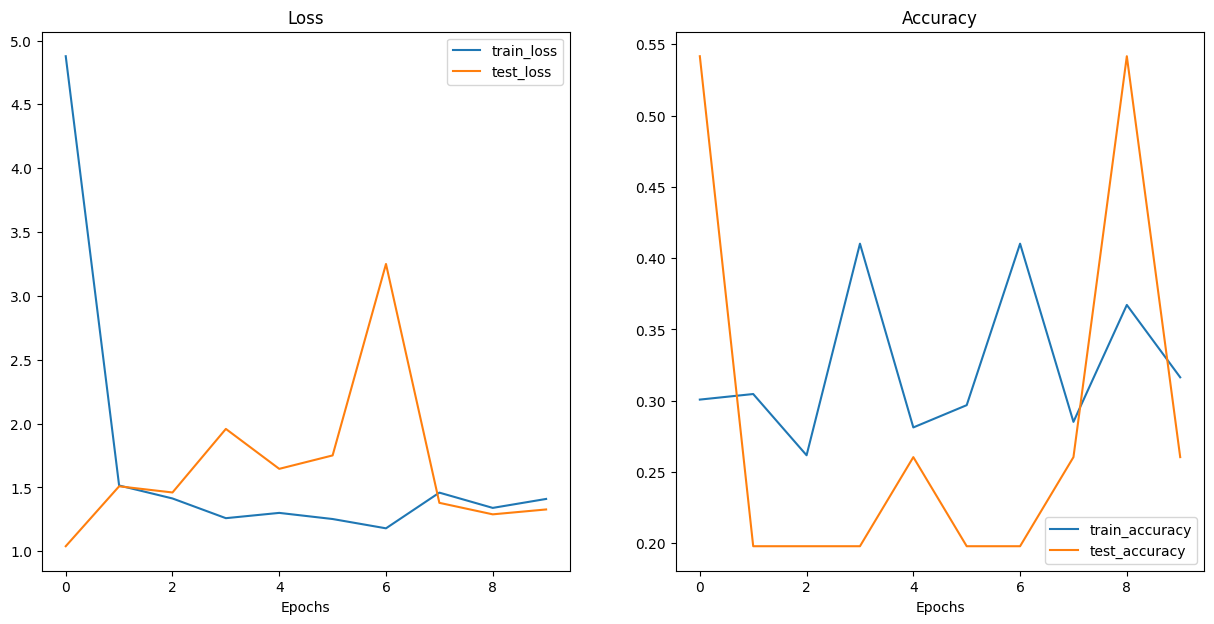

In [93]:

from helper_functions import plot_loss_curves

plot_loss_curves(results)



Hmm it looks like our model is underfitting and overfitting... I wonder what techniques we could use to take care of both at the same time?

See more here: https://www.learnpytorch.io/04_pytorch_custom_datasets/#8-what-should-an-ideal-loss-curve-look-like

## 10. Using a pretrained ViT from `torchvision.models`

Generally, in deep learning if you can use a pretrained model from a large dataset on your own problem, it's often a good place to start.

If you can find a pretrained model and use transfer learning, give it a go, it often achieves great results with little data.

### 10.1 Why use a pretrained model?
- Sometimes data is limited
- Limited training resources
- Get better results faster (sometimes)...

In [13]:
# The following requires torch v0.12+ and torchvision 0.13+
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

2.5.0+cu124
0.20.0+cu124


In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### 10.2 Prepare a pretrained ViT for use with FoodVision Mini (turn it into a feature extractor)


In [32]:
# Get pretrained weights for ViT-Base
pretrained_vit_weights= torchvision.models.ViT_B_16_Weights.DEFAULT

# Setup a ViT model instance with pretrained weights
pretrained_vit= torchvision.models.vit_b_16(weights=pretrained_vit_weights)

# Freeze the base parameters
for param in pretrained_vit.parameters():
    param.requires_grad=False
    
# Update the classifier head
set_seeds()
pretrained_vit.heads= nn.Linear(in_features=768, out_features=len(class_names)).to(device)

In [33]:
pretrained_vit_weights

ViT_B_16_Weights.IMAGENET1K_V1

In [35]:
from torchinfo import summary

summary(model=pretrained_vit,
        input_size=(1, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=13,
        row_settings=["var_names"])
     

Layer (type (var_name))                                      Input Shape   Output Shape  Param #       Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224] [1, 3]        768           Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224] [1, 768, 14, 14] (590,592)     False
├─Encoder (encoder)                                          [1, 197, 768] [1, 197, 768] 151,296       False
│    └─Dropout (dropout)                                     [1, 197, 768] [1, 197, 768] --            --
│    └─Sequential (layers)                                   [1, 197, 768] [1, 197, 768] --            False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768] [1, 197, 768] (7,087,872)   False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768] [1, 197, 768] (7,087,872)   False
│    │    └─EncoderBlock (encoder_layer_2)                   [1, 197, 768] [1, 197, 768] (7,087,872)   False
│    │ 

### 10.3 Preparing data for the pretrained ViT model
When using a pretrained model, you want to make sure your data is formatted in the same way that the model was trained on.

In [48]:
# Get automatic transforms from pretrained ViT weights
vit_transforms= pretrained_vit_weights.transforms()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [49]:
train_dir,test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [50]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names= data_setup.create_dataloaders(
                                                                        train_dir=train_dir,
                                                                        test_dir=test_dir,
                                                                        transform=vit_transforms,
                                                                        batch_size=32,
                                                                        )

### 10.4 Train feature extractor ViT model

In [53]:
from going_modular.going_modular import engine

optimizer= torch.optim.Adam(params=pretrained_vit.parameters(),
                           lr=1e-3)

loss_fn= nn.CrossEntropyLoss()

# Train the classifier head of pretrained ViT
set_seeds()
pretrained_vit_results= engine.train(model=pretrained_vit,
                                    train_dataloader=train_dataloader_pretrained,
                                    test_dataloader=test_dataloader_pretrained,
                                    optimizer=optimizer,
                                    loss_fn=loss_fn,
                                    epochs=10,
                                    device=device)

Epoch: 1 | train_loss: 0.7663 | train_acc: 0.7188 | test_loss: 0.5435 | test_acc: 0.8769
Epoch: 2 | train_loss: 0.3436 | train_acc: 0.9453 | test_loss: 0.3257 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2068 | train_acc: 0.9492 | test_loss: 0.2698 | test_acc: 0.9186
Epoch: 4 | train_loss: 0.1557 | train_acc: 0.9609 | test_loss: 0.2414 | test_acc: 0.9186
Epoch: 5 | train_loss: 0.1244 | train_acc: 0.9727 | test_loss: 0.2271 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1210 | train_acc: 0.9766 | test_loss: 0.2122 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0933 | train_acc: 0.9766 | test_loss: 0.2342 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0793 | train_acc: 0.9844 | test_loss: 0.2268 | test_acc: 0.9081
Epoch: 9 | train_loss: 0.1084 | train_acc: 0.9883 | test_loss: 0.2064 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0646 | train_acc: 0.9922 | test_loss: 0.1795 | test_acc: 0.9176


### 10.5 Plot the loss curves of the pretrained ViT feature extractor model

In [55]:
pretrained_vit_results

{'train_loss': [0.7663078345358372,
  0.34357581473886967,
  0.2068282631225884,
  0.15565911796875298,
  0.12437293585389853,
  0.12098947633057833,
  0.09329073887784034,
  0.07929672228056006,
  0.10844369744881988,
  0.06463209533831105],
 'train_acc': [0.71875,
  0.9453125,
  0.94921875,
  0.9609375,
  0.97265625,
  0.9765625,
  0.9765625,
  0.984375,
  0.98828125,
  0.9921875],
 'test_loss': [0.5435076753298441,
  0.3256823519865672,
  0.2698140988747279,
  0.2414403110742569,
  0.22712680200735727,
  0.21221711734930673,
  0.23415901263554892,
  0.22680298735698065,
  0.20640296240647635,
  0.1795396407445272],
 'test_acc': [0.8768939393939394,
  0.8977272727272728,
  0.9185606060606061,
  0.9185606060606061,
  0.8977272727272728,
  0.9280303030303031,
  0.8882575757575758,
  0.9081439393939394,
  0.9384469696969697,
  0.9176136363636364]}

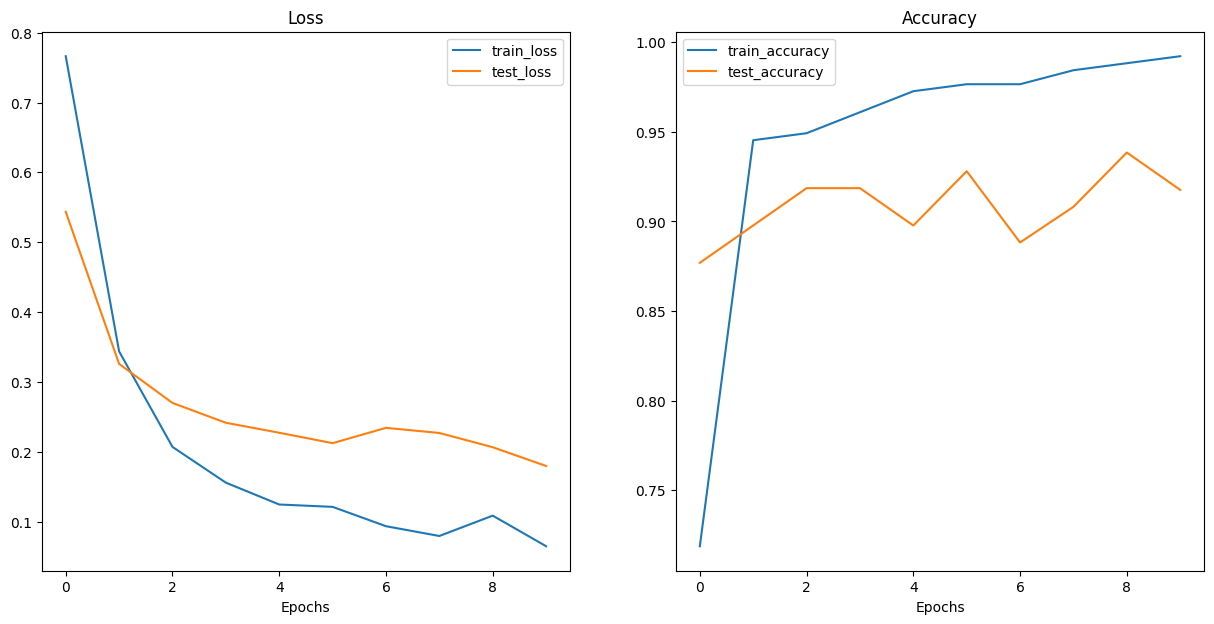

In [58]:
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

### 10.6 Save the best performing ViT model

Now we've got a model that performs quite well, how about we save it to file and then check it's filesize.

We want to check the filesize because if we wanted to deploy a model to say a website/mobile application, we may limitations on the size of the model we can deploy.

E.g. a smaller model may be required due to compute restrictions.

In [61]:
from going_modular.going_modular import utils

utils.save_model(model= pretrained_vit,
                target_dir='models',
                model_name='08_pretrained_vit_feature_extractor_pizza_steak_sushi.pt')

[INFO] Saving model to: models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pt


In [79]:
from pathlib import Path

# Get the model size
pretrained_vit_model_size= Path("models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pt")\
                            .stat().st_size//(1024*1024)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


Our pretrained ViT gets some of the best results we've seen so far on our FoodVision Mini problem, however, the model size is ~11x larger than our next best performing model.

Perhaps the larger model size might cause issues when we go to deploy it (e.g. hard to deploy such a large file/ might not make predictions as fast as a smaller model).

## 11 Predicting on a custom image

data/04-pizza-dad.jpeg already exists, skipping download.


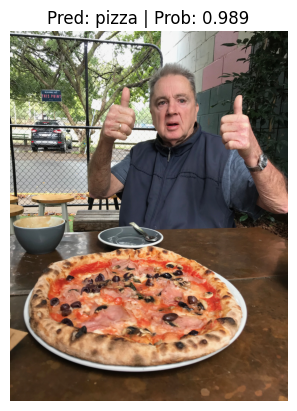

In [87]:
import requests

from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = Path("data/04-pizza-dad.jpeg")

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)
     

In [86]:
custom_image_path

PosixPath('data/04-pizza-dad.jpeg')

# Exercises and extra-curriculum
See exercises and extra-curriculum here: https://www.learnpytorch.io/08_pytorch_paper_replicating/#exercises